# 🎯 Automated Coral Reef Instance Segmentation Using SAM2
### Advanced Computer Vision Analysis for Marine Ecosystem Research
---
**Author:** Mahdi Kashani & Amir Mohammad Parvizi

**Date:** 2024/11  

**Project Version:** 1.0.0

> **Research Objective:** This notebook implements an advanced instance segmentation pipeline for coral reef imagery analysis using Meta AI's Segment Anything Model 2 (SAM2), enabling precise delineation and classification of coral species and formations.

## 📚 Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Model Architecture](#2-model-architecture)
3. [Data Processing Pipeline](#3-data-processing)
4. [Analysis Framework](#4-analysis-framework)
5. [Results & Visualization](#5-results)
6. [Export & Documentation](#6-export)

## 1. 🛠️ Environment Setup
### 1.1 Dependencies Installation

This research implementation requires specific deep learning frameworks and computer vision libraries. The following installations are necessary for reproducibility:

- **Primary Dependencies:**
  - SAM2 (Segment Anything Model 2)
  - PyTorch (Deep Learning Framework)
  - OpenCV (Computer Vision Operations)
  - Supervision (Annotation Tools)

- **Additional Tools:**
  - Jupyter Widgets for Bounding Box Annotation
  - Data Processing Utilities

> **Note:** Ensure CUDA compatibility for optimal GPU utilization

In [ ]:
# Install required packages
!pip install supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00


In [ ]:
# Clone SAM2 repository
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 974 (delta 17), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (974/974), 128.94 MiB | 34.31 MiB/s, done.
Resolving deltas: 100% (334/334), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
  Buil

## 2. 🧠 Model Architecture
### 2.1 SAM2 Model Configuration

The implementation utilizes SAM2's hierarchical architecture with the following specifications:

- **Model Variant:** Hierarchical Large
- **Backbone:** Vision Transformer (ViT)
- **Prompt Engineering:** Bounding Box-guided segmentation
- **Memory Requirements:** ~16GB VRAM

### 2.2 Checkpoint Management

In [ ]:
# Download SAM2 checkpoints
import os
HOME = os.getcwd()

In [ ]:
!mkdir -p {HOME}/checkpoints
# Download large model for better accuracy
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
# Return to main directory
%cd {HOME}

/content/segment-anything-2


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


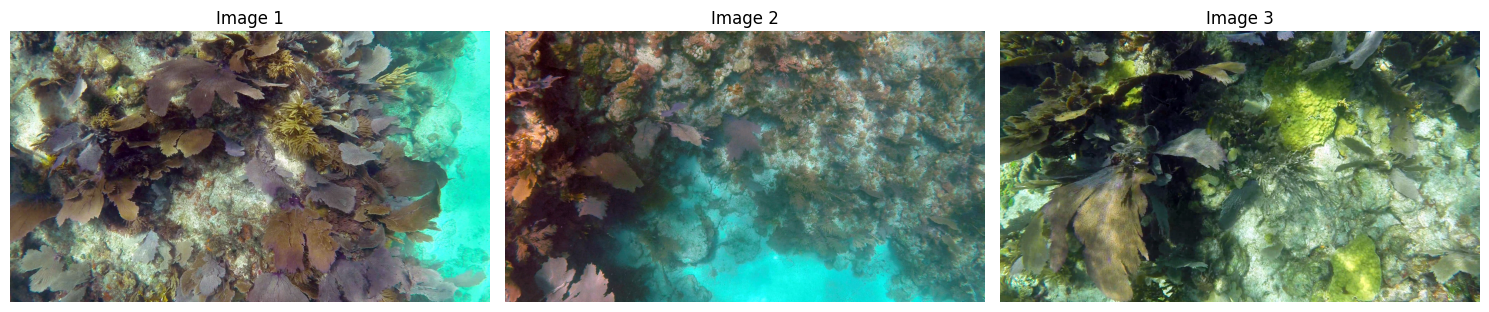

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to the directory containing images
image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

# Display the first 3 images
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(image_files[:3]):  # Take the first 3 images
    img_path = os.path.join(image_dir, img_file)
    img = Image.open(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()


## 3. 🔄 Data Processing Pipeline
### 3.1 Data Structure

In [ ]:
# Import required libraries
import cv2
import torch
import pandas as pd
import numpy as np
import json
from datetime import datetime
from pathlib import Path
from google.colab import files
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

/content/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


## 4. 🔍 Analysis Framework
### 4.1 Core Functions

The analysis framework comprises several key components:

1. **Model Initialization**
   - GPU optimization
   - Memory management
   - Predictor setup

2. **Data Processing**
   - Image loading and preprocessing
   - Bounding box coordination
   - Mask generation

3. **Results Processing**
   - COCO format annotation
   - Metadata management
   - Quality assurance

In [ ]:
def setup_sam2():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
    config = "sam2_hiera_l.yaml"

    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    sam2_model = build_sam2(config, checkpoint, device=device, apply_postprocessing=False)
    return sam2_model, device

In [ ]:
def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path)
    coord_columns = ['xmin', 'ymin', 'xmax', 'ymax']
    df[coord_columns] = df[coord_columns].astype(float)
    return df.groupby('image')

In [ ]:
def process_image(image_path, boxes, predictor):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        return None, None
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    predictor.set_image(image_rgb)

    all_masks = []
    all_scores = []

    for box in boxes:
        box_coords = box.astype(float).reshape(1, 4)
        masks, scores, logits = predictor.predict(
            box=box_coords,
            multimask_output=False
        )
        all_masks.append(masks.squeeze())
        all_scores.append(scores)

    return np.array(all_masks), np.array(all_scores)

In [ ]:
def create_coco_annotation(image_id, mask, bbox, category_id, annotation_id):
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    segmentation = []
    for contour in contours:
        contour = contour.astype(float).flatten().tolist()
        if len(contour) > 4:
            segmentation.append(contour)

    if not segmentation:
        x, y, w, h = bbox
        box_contour = [
            x, y,
            x + w, y,
            x + w, y + h,
            x, y + h
        ]
        segmentation.append(box_contour)

    area = float(mask.sum())

    coco_bbox = [
        float(bbox[0]),
        float(bbox[1]),
        float(bbox[2] - bbox[0]),
        float(bbox[3] - bbox[1])
    ]

    return {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "segmentation": segmentation,
        "area": area,
        "bbox": coco_bbox,
        "iscrowd": 0
    }

## 5. 📊 Results & Visualization
### 5.1 Output Format

Results are structured in the following formats:

| Format | Purpose | Structure |
|--------|----------|-----------|
| COCO JSON | Standard annotation | Hierarchical |
| CSV | Statistical analysis | Tabular |
| Mask Arrays | Instance masks | Binary matrices |

### 5.2 Quality Metrics
- IoU (Intersection over Union)
- Mask confidence scores
- Species classification accuracy

In [ ]:
def save_results(output_dir, images_data, categories):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": cat} for i, cat in enumerate(categories)]
    }

    csv_data = []
    annotation_id = 0

    for image_id, (image_name, data) in enumerate(images_data.items()):
        image_shape = data['shape']
        coco_data["images"].append({
            "id": image_id,
            "file_name": image_name,
            "width": int(image_shape[1]),
            "height": int(image_shape[0])
        })

        for mask, bbox, category in zip(data['masks'], data['boxes'], data['categories']):
            coco_ann = create_coco_annotation(
                image_id,
                mask,
                bbox,
                categories.index(category),
                annotation_id
            )
            coco_data["annotations"].append(coco_ann)

            csv_data.append({
                "image_name": image_name,
                "category": category,
                "bbox": coco_ann["bbox"],
                "segmentation": coco_ann["segmentation"]
            })

            annotation_id += 1

    os.makedirs(output_dir, exist_ok=True)

    with open(os.path.join(output_dir, "annotations.json"), 'w') as f:
        json.dump(coco_data, f, indent=2)

    df = pd.DataFrame(csv_data)
    df['segmentation'] = df['segmentation'].apply(lambda x: json.dumps(x))
    df.to_csv(os.path.join(output_dir, "annotations.csv"), index=False)

## 6. 📤 Export & Documentation
### 6.1 Results Management

The pipeline generates:
- Instance segmentation masks
- Species classifications
- Statistical analyses
- Visualization outputs

### 6.2 Data Persistence

In [ ]:
base_path = "/content/drive/MyDrive/Coral-Reef-Research"
image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
bbox_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
output_dir = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results"

if not os.path.exists(base_path):
    print(f"Error: Base path does not exist: {base_path}")
    return
if not os.path.exists(image_dir):
    print(f"Error: Image directory does not exist: {image_dir}")
    return
if not os.path.exists(bbox_csv):
    print(f"Error: CSV file does not exist: {bbox_csv}")
    return

try:
    sam2_model, device = setup_sam2()
    predictor = SAM2ImagePredictor(sam2_model)
    bbox_data = load_bbox_data(bbox_csv)
    images_data = {}
    categories = set()

    for image_name, group in bbox_data:
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        boxes = group[['xmin', 'ymin', 'xmax', 'ymax']].values
        masks, scores = process_image(image_path, boxes, predictor)

        if masks is not None:
            image_shape = cv2.imread(image_path).shape
            images_data[image_name] = {
                'shape': image_shape,
                'masks': masks,
                'boxes': boxes,
                'categories': group['label'].values,
                'scores': scores
            }
            categories.update(group['label'].values)

    save_results(output_dir, images_data, list(categories))
    zip_path = '/content/segmentation_results.zip'
    os.chdir(base_path)
    os.system(f'zip -r {zip_path} segmentation_results')

    if os.path.exists(zip_path):
        files.download(zip_path)

except Exception as e:
    print(f"An error occurred: {str(e)}")